##### Yona MELLUL - 3800646
# Face Detection & Analysis

In [1]:
from sklearn.linear_model import LinearRegression
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
from skimage.transform import resize
import pickle
import numpy as np
import os
import PIL
from PIL import Image
import cv2

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

# 1 - Data preprocessing

## 1.1 - Data download

In [2]:
def read_paths(file_name):
    with open(file_name) as f:
        return np.array([line.rstrip("\n") for line in f])


train_img_path = read_paths("data/300w_train_images.txt")
train_landmark_paths = read_paths("data/300w_train_landmarks.txt")
test_img_path = read_paths("data/helen_testset.txt")
test_landmark_paths = read_paths("data/helen_testset_landmarks.txt")


## 1.2 - Data visualisation
To discover the data, the first step is to parse the 300w_train_images.txt and to randomly
display a dozen of images with the corresponding landmarks.

(400, 311, 3)
(1748, 1703, 3)
(788, 702, 3)
(480, 320, 3)


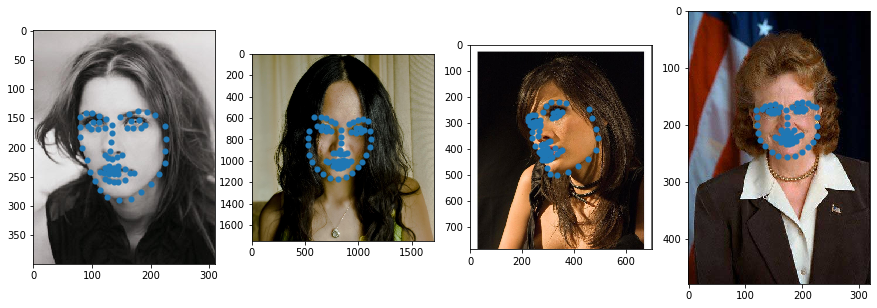

In [3]:
indices = np.random.choice(len(train_img_path), 4)
fig = plt.figure(figsize=(15, 20))

for i, line in enumerate(train_img_path[indices]):
    pts = np.loadtxt("data/" + train_landmark_paths[indices[i]])
    #print(pts[65:])
    try:
        img = mpimg.imread("data/" + line)
        print(img.shape)
    except Exception as e:
        print(f"Exception: {e}")

    ax = fig.add_subplot(1, 4, i + 1)
    ax.scatter(pts[:, 0], pts[:, 1], linewidths=0.1)
    ax.imshow(img)

## 1.3 - Data augmentation
For each image of the training set, you should:
##### 1. Compute the parameters of the bounding box of the facial landmarks
##### 2. Widen this bounding box by 30 %, crop the image with these new dimensions, and resize the image in 128 ∗ 128 and save it on the disk.
##### 3. Compute the new landmark coordinates for this resized image. This new position is the ground truth (you should display some images with facial landmarks to check if this preprocess went well).

In [4]:
#1
def bbox(landmarks):
    xmin, ymin = int(landmarks[:, 0].min()), int(landmarks[:, 1].min())
    xmax, ymax = int(landmarks[:, 0].max()), int(landmarks[:, 1].max())
    return xmin, xmax, ymin, ymax

#2
def extend_bbox(image, landmarks):
    xmin, xmax, ymin, ymax = bbox(landmarks)
    image_height, image_width, _ = image.shape
    
    width = xmax - xmin
    height = ymax - ymin
    
    extend_width = width * 0.3
    extend_height = height * 0.3
    
    
    # Extend the bounding box by 30% while ensuring it doesn't exceed image bounds
    new_xmin = int(max(0, xmin - (extend_width / 2)))  # Extend half of the width to both sides
    new_xmax = int(min(image_width, xmax + (extend_width / 2)))
    new_ymin = int(max(0, ymin - (extend_height / 2)))  # Extend half of the height to both sides
    new_ymax = int(min(image_height, ymax + (extend_height / 2)))

    return new_xmin, new_xmax, new_ymin, new_ymax

def all_preprocess(image, landmarks):
    xmin, xmax, ymin, ymax = extend_bbox(image, landmarks)
    new_img = image[ymin:ymax, xmin:xmax]
    new_img = resize(new_img, (128, 128))
    return new_img

#3
def transform_landmarks(image, pts, new_image_size = (128, 128)):
    writtenpts = ""
    xmin, xmax, ymin, ymax = extend_bbox(image, pts)
    h, w = ymax-ymin, xmax-xmin
    newpts = np.zeros_like(pts)
    for i, pt in enumerate(pts):
        newpts[i, 0] = 128 * (pt[0] - xmin) / w
        newpts[i, 1] = 128 * (pt[1] - ymin) / h
        #print(str(newpts[i, 0])+" "+str(newpts[i, 1])+"\n")
        writtenpts += str(newpts[i, 0])+" "+str(newpts[i, 1])+"\n"
    #return newpts
    return newpts, writtenpts

#4
def duplicateChannel(img):
    #img = img.convert('L')
    #np_img = np.array(img, dtype=np.uint8)
    img = np.dstack([img, img, img])
    #img = Image.fromarray(np_img, 'RGB')
    return img

def check3D(img):
    if len(img.shape)== 2:
        return duplicateChannel(img)
    if len(img.shape)==3:
        return img
#def mean_face()


##### Saving the data after all preprocessing is done

In [5]:
#TRAIN
done = True
if not done:
    # Check and create directory before the loop
    if not os.path.exists("data/preprocessed_trainset"):
        os.mkdir("data/preprocessed_trainset")
    
    for i, line in enumerate(train_img_path):   
        if i%100 == 0:
            print("i = ", i)
        pts = np.loadtxt("data/" + train_landmark_paths[i])
        try :
            img = mpimg.imread("data/" + line)
            if len(img.shape) != 3:
                img = check3D(img)
        except Exception as e:
            print(f"i = {i} : Exception: {e}")
            continue
        #print("img.shape : ",img.shape)
        newpts, writtenpts = transform_landmarks(img, pts)
        try:
            new_img = all_preprocess(img, pts)
        except ValueError as e:
            print(f"i = {i} : Exception: {e}")
            continue

        with open(f"data/preprocessed_trainset/figure{i}.pts", "w") as f:
            f.write(writtenpts)

        plt.imsave(f"data/preprocessed_trainset/figure{i}.png", new_img)    


In [6]:
#TESTSET
done = True
if not done:
    # Check and create directory before the loop
    if not os.path.exists("data/preprocessed_testset"):
        os.mkdir("data/preprocessed_testset")
    
    for i, line in enumerate(test_img_path):   
        if i%100 == 0:
            print("i = ", i)
        pts = np.loadtxt("data/" + test_landmark_paths[i])
        try :
            img = mpimg.imread("data/" + line)
            if len(img.shape) != 3:
                img = check3D(img)
        except Exception as e:
            print(f"i = {i} : Exception: {e}")
            continue
        #print("img.shape : ",img.shape)
        newpts, writtenpts = transform_landmarks(img, pts)
        try:
            new_img = all_preprocess(img, pts)
        except ValueError as e:
            print(f"i = {i} : Exception: {e}")
            continue

        with open(f"data/preprocessed_testset/figure{i}.pts", "w") as f:
            f.write(writtenpts)

        plt.imsave(f"data/preprocessed_testset/figure{i}.png", new_img)    


##### Checking it went well

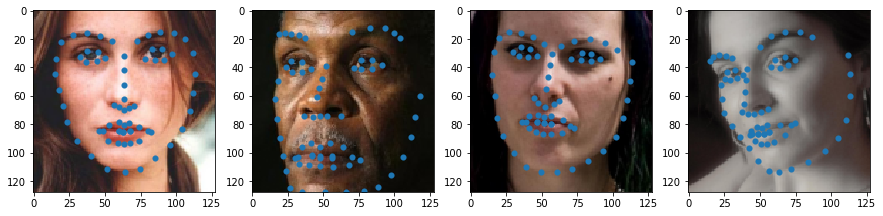

In [7]:
indices = np.random.choice(len(train_img_path), 4)

fig = plt.figure(figsize=(15, 20))
for i, line in enumerate(train_img_path[indices]):
    pts = np.loadtxt("data/preprocessed_trainset/figure"+str(indices[i])+".pts")
    try:
        img = mpimg.imread("data/preprocessed_trainset/figure"+str(indices[i])+".png")
    except Exception as e:
        print(f"Exception: {e}")

    ax = fig.add_subplot(1, 4, i + 1)
    ax.scatter(pts[:, 0], pts[:, 1], linewidths=0.1)
    ax.imshow(img)

[117 194 254 259]


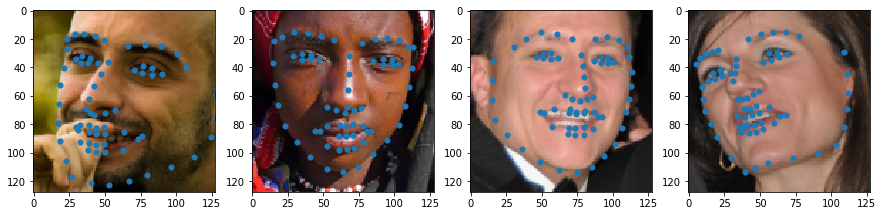

In [8]:
indices = np.random.choice(len(test_img_path), 4)
print(indices)
fig = plt.figure(figsize=(15, 20))
for i, line in enumerate(test_img_path[indices]):
    pts = np.loadtxt("data/preprocessed_testset/figure"+str(indices[i])+".pts")
    try:
        img = mpimg.imread("data/preprocessed_testset/figure"+str(indices[i])+".png")
    except Exception as e:
        print(f"Exception: {e}")

    ax = fig.add_subplot(1, 4, i + 1)
    ax.scatter(pts[:, 0], pts[:, 1], linewidths=0.1)
    ax.imshow(img)

##### 4. Compute the mean position of each landmark on the training set. It constitutes the mean shape of the face.

In [9]:
done = False
all_pts = []
if not done:
    for i, line in enumerate(train_img_path):
        pts = np.loadtxt("data/preprocessed_trainset/figure"+str(i)+".pts")
        all_pts.append(pts)
        
    mean_face = np.array(all_pts).mean(axis = 0)

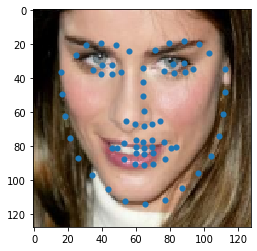

In [10]:
plt.imshow(mpimg.imread("data/preprocessed_trainset/figure2000.png"))
plt.scatter(mean_face[:, 0], mean_face[:, 1], linewidths=0.1)
plt.show()

##### 5. Initialize the mean shape in each image and generate 10 random perturbations (in translation and scaling) around this position. The amplitude of these perturbations will be ±20% and ±20px for scaling and translation respectively. 

In [11]:
nb_images = len(train_landmark_paths)
done = True
if not done:
    for i in range(nb_images):
        print(f"\r{i+1}/{nb_images}", end="")

        img = mpimg.imread(f"data/preprocessed_trainset/figure{i}.png")
        for j in range(10):
            newPts = mean_face.copy()

            tx = np.random.randint(-20, 20)
            ty = np.random.randint(-20, 20)
            sx = np.random.randint(-20, 20) / 100
            sy = np.random.randint(-20, 20) / 100

            perturb = []
            for pt in newPts:
                pt[0] = min(max(pt[0] * (1 + sx) + tx, 0), 128)
                pt[1] = min(max(pt[1] * (1 + sy) + ty, 0), 128)
                perturb.append(f"{pt[0]} {pt[1]}")

            perturb_str = "\n".join(perturb)
            with open(f"data/preprocessed_trainset/figure{i}_{j}.pts", "w") as f:
                f.write(perturb_str)

[281 212 237 236]
(68, 2)
(68, 2)
(68, 2)
(68, 2)


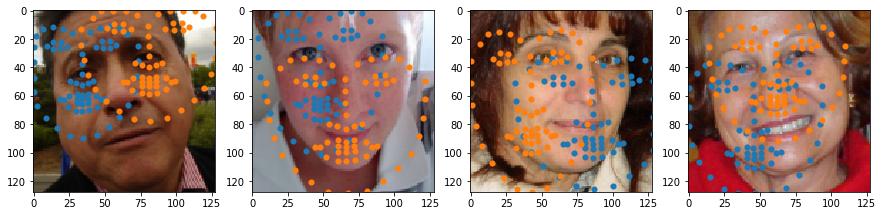

In [12]:
indices = np.random.choice(len(test_img_path), 4)
print(indices)
fig = plt.figure(figsize=(15, 20))
for i, line in enumerate(test_img_path[indices]):
    pts = np.array([np.loadtxt("data/preprocessed_trainset/figure"+str(indices[i])+"_"+str(j)+".pts") for j in range(4)])
    print(pts[1].shape)
    try:
        img = mpimg.imread("data/preprocessed_trainset/figure"+str(indices[i])+".png")
    except Exception as e:
        print(f"Exception: {e}")

    ax = fig.add_subplot(1, 4, i + 1)
    ax.scatter(pts[0][:, 0], pts[0][:, 1], linewidths=0.1)
    ax.scatter(pts[1][:, 0], pts[1][:, 1], linewidths=0.1)
    #ax.scatter(pts[2][:, 0], pts[2][:, 1], linewidths=0.1)
    #ax.scatter(pts[3][:, 0], pts[3][:, 1], linewidths=0.1)

    ax.imshow(img)

##### Why do we generate these perturbations? 

- **Diversity:** Perturbations create diverse facial shapes, expressions, and orientations, making models more adaptable to real-world variations.
- **Augmented Data:** Expands the dataset, reducing overfitting and improving model generalization.


##### How could they be estimated automatically?

- **Statistical Analysis:** Analyzing dataset variations helps estimate scaling, translation, and rotation parameters.
- **Machine Learning:** Regression models or data-driven approaches predict perturbation parameters from images or landmark data.
- **Shape Models:** Statistical shape models or alignment techniques estimate variations for automated perturbation generation.

At the end of this step, you have a clean dataset that you can use to train et evaluate
your model. You should apply the same modifications to your test set (without the random
perturbations) to be in the same condition for evaluation.

# 2 - Training of a single regressor

In this part, we want to estimate a displacement of the landmarks, starting from a mean model
(i.e. using computer vision and machine learning tools, to learn a function f : I, s0 → δs such
that s0 + δs ≈ s
∗
in the sense of least squares).

## 2.1 - Feature extraction
To do so, a first step is to extract a local representation around each landmark.
##### 1. Why do we not directly use the raw value of the image pixels as a representation ?

Using raw pixel values directly for landmark displacement has limitations:

- **Noise Sensitivity:** Prone to noise, impacting accuracy.
- **High Dimensionality:** Results in complex, redundant data.
- **Illumination Impact:** Susceptible to lighting changes.
- **Lack of Semantics:** Doesn't understand content meaning.
- **Context Ignorance:** Fails to consider nearby context.
- **Feature Complexity:** Requires manual extraction, lacks invariance.

Instead, local representations (like SIFT, HOG) offer structured, contextual information, aiding robust, semantically meaningful landmark displacement estimation compared to raw pixels.

##### 2. Create, for each current landmark of the mean model si0i=0,...,68, a cv2.keyPoint object by specifying its coordinates, and setting the size of the surrounding patch to 20px.
##### 3. Use the OpenCV sift.compute function to compute a SIFT feature around each landmark. What is the dimension of each feature?
The dimension of each feature is 128.
##### 4. For each image, concatenate all the computed features from each landmarks. What is the dimension of this feature vector?
Each image has 68 landmarks. Therefore, the dimension of the feature vector is 68*128 = 8704

In [13]:
#keyPoints = [cv2.KeyPoint(x, y, 20) for x, y in mean_face]

In [14]:
def getDescriptors(image, keyPoints):
    # Initialize the SIFT detector and extractor
    sift = cv2.SIFT_create()
    # Compute SIFT features for each keypoint
    _, descriptors = sift.compute(image, keyPoints)

    # The dimension of each feature (SIFT descriptor)
    #descriptor_dimension = descriptors.shape[1]  # This gives the dimension of each SIFT descriptor
    return descriptors

In [15]:
def featureVectors(landmarks, paths, size, prefix, output_file):
    keyPoints = [cv2.KeyPoint(x, y, size) for x, y in landmarks]
    descriptors_list = []

    for i, path in enumerate(paths):
        print(f"\r{i+1}/{len(paths)}", end="")
        img = cv2.imread(f"{prefix}{path}.png")
        desc = getDescriptors(img, keyPoints).flatten()
        descriptors_list.append(desc)

    X = np.column_stack(descriptors_list)
    with open(output_file, "wb") as file:
        pickle.dump(X, file)
    return X


In [16]:
# TRAIN
nb_selected_img = 100000
print("train:")
if os.path.exists("data/X0_train.pkl"):
    with open("data/X0_train.pkl", "rb") as file:
        X0_train = pickle.load(file)
else:
    X0_train = featureVectors(
        mean_face,
        [f"figure{i}" for i in range(min(len(train_landmark_paths), nb_selected_img))],
        20,
        "data/preprocessed_trainset/",
        "data/X0_train.pkl",
    )

print("\n\nX0_train.shape =", X0_train.shape)


train:


X0_train.shape = (8704, 3148)


In [17]:
# test
nb_selected_img = 100000
print("test:")
if os.path.exists("data/X0_test.pkl"):
    with open("data/X0_test.pkl", "rb") as file:
        X0_test = pickle.load(file)
else:
    X0_test = featureVectors(
        mean_face,
        [f"figure{i}" for i in range(min(len(test_landmark_paths), nb_selected_img))],
        20,
        "data/preprocessed_testset/",
        "data/X0_test.pkl",
    )

print("\n\nX0_test.shape =", X0_test.shape)


test:


X0_test.shape = (8704, 330)


## 2.2 - Dimensionality reduction
At this stage we get a matrix X0 ∈ RM×N whose columns contain the different images from the
database, and lines corresponds to the extracted features. A second step consists in reducing
the dimension of the obtained descriptors.
Reminder: by computing the PCA (principal component analysis), we get a projection matrix
A0 ∈ RM0×M, with M0 < M, and such that the total variance of the projected data X˜
0 = A0X0
is greater or equal to 98% of the total variance of the original data X0.
##### 1. What is the main interest of this dimensionality reduction? Could you cite some other dimensionality reduction methods for machine learning?

The main interests of this dimensionality reduction are:
1. **Computational Efficiency:** Reducing dimensions accelerates model training and inference, especially with large datasets, by simplifying computations.
2. **Overfitting Mitigation:** Decreasing the number of features minimizes the risk of overfitting, enhancing model generalization to unseen data.


Other Dimensionality Reduction Methods are **LDA (Linear Discriminant Analysis)** which focuses on maximizing class separability, often used in classification tasks, **ICA (Independent Component Analysis)** which extracts statistically independent components from data mixtures, or **Autoencoders** which is a neural network-based approach for unsupervised feature learning through data compression and reconstruction.


##### 2. Use the PCA (OpenCV or skimage) to keep 98% of the total variance of the features

In [18]:
#TRAIN
if os.path.exists("train_mean.pkl") and os.path.exists("train_eigenvectors.pkl") and os.path.exists("train_eigenvalues.pkl") :
    with open("data/train_mean", "rb") as file:
        mean = pickle.load(file)      
    with open("data/train_eigenvectors", "rb") as file:
        eigenvectors = pickle.load(file)
    with open("data/train_eigenvalues", "rb") as file:
        eigenvalues = pickle.load(file)
else:
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(X0_train.transpose(), mean, retainedVariance=0.98)

    with open("data/train_mean", "wb") as file:
        pickle.dump(mean, file)
    with open("data/train_eigenvectors", "wb") as file:
        pickle.dump(eigenvectors, file)
    with open("data/train_eigenvalues", "wb") as file:
        pickle.dump(eigenvalues, file)

In [19]:
#TEST
if os.path.exists("test_mean.pkl") 
and os.path.exists("test_eigenvectors.pkl") 
and os.path.exists("test_eigenvalues.pkl") :
    with open("data/test_mean", "rb") as file:
        mean = pickle.load(file)      
    with open("data/test_eigenvectors", "rb") as file:
        eigenvectors = pickle.load(file)
    with open("data/test_eigenvalues", "rb") as file:
        eigenvalues = pickle.load(file)
else:
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(X0_train.transpose(), mean, retainedVariance=0.98)

    with open("data/test_mean", "wb") as file:
        pickle.dump(mean, file)
    with open("data/test_eigenvectors", "wb") as file:
        pickle.dump(eigenvectors, file)
    with open("data/test_eigenvalues", "wb") as file:
        pickle.dump(eigenvalues, file)

SyntaxError: invalid syntax (<ipython-input-19-a5140664aa50>, line 2)

##### 3. What are the dimensions of the new resulting matrix X˜0?

In [ ]:
X0_tilde = np.matmul(train_eigenvectors, X0_train)
print("X0_tilde.shape:", X0_tilde.shape)

## 2.3 - Displacement estimation
Starting from this new representation X˜ = A0X0, we want to estimate the linear regression that
predict δs, the displacement of the landmarks from the reduced extracted features. Formally:
δ
0
s = argminδs
||δ
∗
s − δs||2
(1)
whith δ
∗
s ∈ R
D (D = 136), the optimal displacement vector from the initial position s0. By
setting δs = R0X˜
0 + b0, it is equivalent to:
argminR0,b0
||δ
∗
s − R0X˜
0 − b0||2
(2)
##### 1. Compute the least square estimation of R0 and b0 (b0 can be removed by adding and extra row of ones to X˜0)


In [ ]:
# Augmenting X_tilde_0 with an extra row of ones
X_augmented = np.vstack([X0_tilde, np.ones(X0_tilde.shape[1])])

# Computing least squares estimation
R_0, b_0 = np.linalg.lstsq(X_augmented.T, delta_s, rcond=None)[0:2]

##### 2. Compute the prediction error (mean absolute error) on the training set. Display s0 the initial position of the model (in red) and s0 + δs the displaced landmarks (in green) for the first image of the training set. What can we conclude ?

##### 3. Why this prediction error is not relevant to evaluate our methods ?

This prediction error is not relevant to evaluate our methods because it's evaluated on images that were used for the training. We need to use the test set.

##### 4. Compute the prediction error on the test set and display s0 the initial position of the model (in red) and s0 + δs the displaced landmarks (in green) for the 5 first images of the test set. What can we conclude ?